# Instar Drafting

## Load Modules

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
print(tf.__version__)

2.6.0


## Load the data

In [25]:
# (mnist_train, mnist_test), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Train the model

In [4]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(0.001),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
# )

# model.fit(
#     ds_train,
#     epochs=6,
#     validation_data=ds_test,
# )

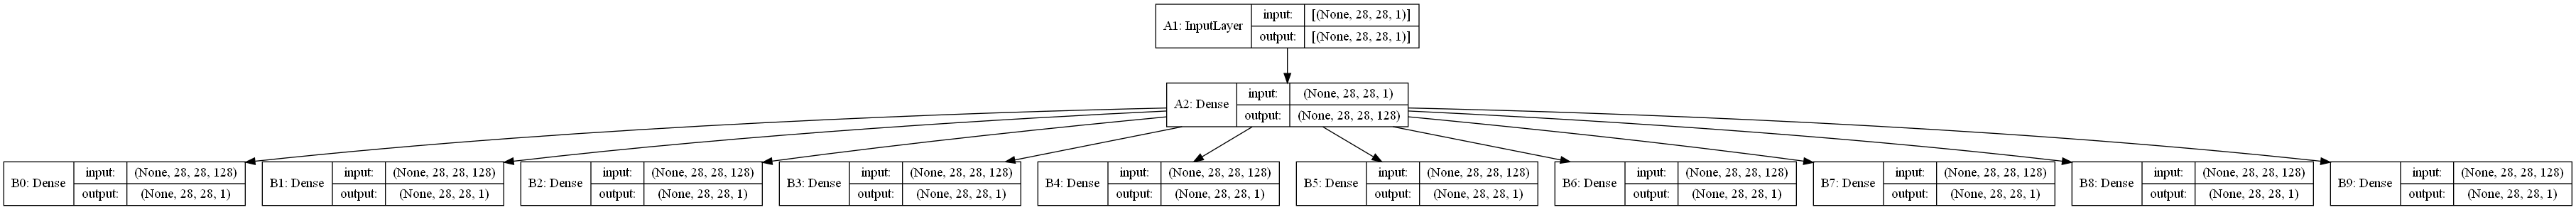

In [59]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

dim = 28


A1 = Input(shape=(dim,dim,1),name='A1')
# A11 = Flatten(name='AFlatten')(A1)
# A1 = Input(shape=(dim**2,),name='A1')
# A1 = Flatten(input_shape=(28, 28), name='A1')
A2 = Dense(128, activation='relu',name='A2')(A1)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
# #   tf.keras.layers.Dense(10)
# ])


# head_nodes = tf.keras.models.Sequential([
#     model,
#     tf.keras.layers.Dense(1, activation='relu'),
# ])
head_nodes = [Dense(1, activation='relu',name='B'+str(i))(A2) for i in range(10)]
# head_nodes = [Dense(1, activation='relu',name='B'+str(i))(model) for i in range(10)]


merged = Model(inputs=[A1],outputs=[head_nodes])
plot_model(merged,to_file='demo.png',show_shapes=True)
# plot_model(head_nodes,to_file='demo.png',show_shapes=True)

In [48]:
y = merged(tf.ones((1,dim**2)))
print(y[0])

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.6912179]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.62704575]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.5887864]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.826129]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7964359]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.3449031]], dtype=float32)>]


In [60]:
def l2_penalty(theta, theta_A):
    penalty = 0
    for i, theta_i in enumerate(theta):
        penalty += tf.math.reduce_sum(tf.math.square(theta_i - theta_A[i]))
    return 0.5*penalty

def train_art(model_bu, train, test, epochs=6):
    # We'll only compute Fisher once, you can do it whenever
    # F = compute_precision_matrices(model, task_A_set, num_batches=1000)

    theta_bu = {n: p.value() for n, p in enumerate(model_bu.trainable_variables.copy())}
    
    accuracy_bu = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    loss_bu = tf.keras.metrics.SparseCategoricalCrossentropy('loss')

    for batch, (imgs, labels) in enumerate(train):
        for img in imgs:
            with tf.GradientTape() as tape:
                # print(np.shape(img))
                pred = model_bu(img)
                # total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
                total_loss = model.loss(labels, pred)
#                 # preds = model(imgs)
#     #         total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
#     #     grads = tape.gradient(total_loss, model.trainable_variables)
#     #     model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
#     #     accuracy.update_state(labels, preds)
#     #     loss.update_state(labels, preds)
#     #     print("\rEpoch: {}, Batch: {}, Loss: {:.3f}, Accuracy: {:.3f}".format(
#     #         epoch+1, batch+1, loss.result().numpy(), accuracy.result().numpy()), flush=True, end=''
#     #         )
#     #     print("")

train_art(merged, ds_train, ds_test, epochs=1)
# train_art(head_nodes, ds_train, ds_test, epochs=1)


AttributeError: 'Sequential' object has no attribute 'loss'

In [16]:
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.utils import plot_model

# A1 = Input(shape=(30,),name='A1')
# A2 = Dense(8, activation='relu',name='A2')(A1)
# A3 = Dense(30, activation='relu',name='A3')(A2)

# B2 = Dense(40, activation='relu',name='B2')(A2)
# B3 = Dense(20, activation='relu',name='B3')(B2)

# merged = Model(inputs=[A1],outputs=[A3,B3])
# plot_model(merged,to_file='demo.png',show_shapes=True)

## EWC + ART training

In [5]:
# dim = 28
# model_bu = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(dim, dim)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])

# model_bu.compile(
#     optimizer=tf.keras.optimizers.Adam(0.001),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
# )

class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

# Let's assume we are reusing the Linear class
# with a `build` method that we defined above.

class MLPBlock(keras.layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(1)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)


mlp = MLPBlock()
y = mlp(tf.ones(shape=(3, 64)))  # The first call to the `mlp` will create the weights
print("weights:", len(mlp.weights))
print("trainable weights:", len(mlp.trainable_weights))

weights: 6
trainable weights: 6


In [23]:
# model_bu_base = 

# inputs = keras.Input(shape=(784,))

# dense = layers.Dense(64, activation="relu")
# x = dense(inputs)

# x = layers.Dense(64, activation="relu")(x)
# # x = dense(x)
# outputs = layers.Dense(10)(x)

# model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

# model.summary()

In [6]:
# def l2_penalty(theta, theta_A):
#     penalty = 0
#     for i, theta_i in enumerate(theta):
#         penalty += tf.math.reduce_sum(tf.math.square(theta_i - theta_A[i]))
#     return 0.5*penalty

# def train_art(model_bu, model_td, train, test, epochs=6):
#     # We'll only compute Fisher once, you can do it whenever
#     # F = compute_precision_matrices(model, task_A_set, num_batches=1000)

#     theta_bu = {n: p.value() for n, p in enumerate(model_bu.trainable_variables.copy())}
#     theta_td = {n: p.value() for n, p in enumerate(model_td.trainable_variables.copy())}
    
#     accuracy_bu = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#     loss_bu = tf.keras.metrics.SparseCategoricalCrossentropy('loss')

#     accuracy_td = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#     loss_td = tf.keras.metrics.SparseCategoricalCrossentropy('loss')

#     for epoch in range(epochs):
#         accuracy_bu.reset_states()
#         loss_bu.reset_states()
#         accuracy_td.reset_states()
#         loss_td.reset_states()

#         # for batch, (imgs, labels) in enumerate(train):
#         #     for img in imgs:
#         #         with tf.GradientTape() as tape:
#         #             pred = model_bu(img)
#         #             total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
#                 # preds = model(imgs)
#     #         total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
#     #     grads = tape.gradient(total_loss, model.trainable_variables)
#     #     model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
#     #     accuracy.update_state(labels, preds)
#     #     loss.update_state(labels, preds)
#     #     print("\rEpoch: {}, Batch: {}, Loss: {:.3f}, Accuracy: {:.3f}".format(
#     #         epoch+1, batch+1, loss.result().numpy(), accuracy.result().numpy()), flush=True, end=''
#     #         )
#     #     print("")

# train_art(model_bu, model_td, ds_train, ds_test, epochs=1)
